# Random Gaussian Walker

In order to test the capabilities of the TrackEddy time-tracking algorithm
a fwe idealised perturbation field were generated. All the examples
consist on a number of Gaussians which moves stochasticly or commonly known as random walkers(initial conditions and time evolution).

Each Gaussian perturbation starts at location (x,y) and at each
time step it moves +1 or -1 in the x and y axis with equal probability and allowing it to move in multiple directions as shown below.

\begin{array} {c c c}
\nwarrow & \uparrow & \nearrow\\
\leftarrow & \cdot & \rightarrow\\
\swarrow & \downarrow & \searrow\\
\end{array}

Then TrackEddy was implemented to verify the capabilities of the tracking
and reconstruction of the field.

Tracking of each individual Gaussian as it moves as a random walker.

In [1]:
import sys
from netCDF4 import Dataset
import os
import cmocean as cm
from trackeddy.tracking import *
from trackeddy.datastruct import *
from trackeddy.geometryfunc import *
from trackeddy.init import *
from trackeddy.physics import *
#from trackeddy.plotfunc import *
from numpy import *
from pylab import *
import cmocean as cm
import random
%matplotlib inline
import scipy.optimize as opt

In [48]:
def go_right(indexs,step):
    return [0,step]
    
def go_upright(indexs,step):
    return [step,step]
    
def go_up(indexs,step):
    return [step,0]

def go_upleft(indexs,step):
    return [step,-step]
    
def go_left(indexs,step):
    return [0,-step]

def go_downleft(indexs,step):
    return [-step,-step]
    
def go_down(indexs,step):
    return [-step,0]

def go_downright(indexs,step):
    return [-step,step]

In [3]:
from random import randrange, uniform
import numpy as np

def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def moveGaussian(size,fwhm,center,timestep):
    z=np.zeros([timestep,size,size])
    for tt in range(0,timestep):
        z[tt,:,:]=makeGaussian(size, fwhm, (center[tt,0],center[tt,1]))
    return z

def RandGaussian(size,time,nn):
    zz=np.zeros([time,size,size])
    zz1=zz*1
    ii=0
    while ii < nn:
        xx=(randrange(0, 100)/100.0)*size
        xxx=(randrange(0, 100)/100.0)*size
        yyy=(randrange(0, 100)/100.0)*size
        if xx > size/8 and xx < size/4:
            center=array([[xxx,yyy+x] for x in linspace(size*0.1,size*0.9,time)])
            #print(center)
            for tt in range(0,time):
                zz1[tt,:,:]=makeGaussian(size, xx,(center[tt,0],center[tt,1]))
            zz=zz+zz1
            ii=ii+1
    return zz

In [4]:
size=600
time=1
zzn=-RandGaussian(size,time,10)
zzp=RandGaussian(size,time,10)

In [5]:
x=linspace(0,1,100)
y=linspace(0,1,100)
X,Y=meshgrid(x,y)
gauss=twoD_Gaussian((X,Y,1,0.5,0.5), 0.1, 0.1, 0, slopex=0, slopey=0, offset=0).reshape(len(x),len(y))


In [43]:
def dist(loc1,loc2):
    return sqrt((loc1[0]-loc2[0])**2 + (loc2[1]-loc1[1])**2)

n=6
steps=1
x=linspace(0,5,100)
y=linspace(0,5,100)

xlen=len(x)
ylen=len(y)

count=0

X,Y=meshgrid(x,y)
a=b=0.1
count=a
data=zeros(shape(X))
diagnostics=True
rmlist=[]

eddies={'eddy_n%s' % ii:{'loc':[[randint(0,xlen), randint(0,ylen)]],'grow':True,'radius':a,\
                         'amp':random.choice([-1,1])} for ii in range(n)}
#print(eddies)
def checkposition(eddies,x,y,):
    for key,item in eddies.items():
        for key1,item1 in eddies.items():
            xc=item['loc'][0][0]
            yc=item['loc'][0][1]
            xc1=item1['loc'][0][0]
            yc1=item1['loc'][0][1]
            distance=dist([x[xc],y[yc]],[x[xc1],y[yc1]])
            #print(distance)
            checker = (distance < 1*a or distance < 1*b ) and key1!=key
            #print(checker)
            while checker:
                newx=randint(0,xlen)
                newy=randint(0,ylen)
                eddies[key1]={'loc':[[newx, newy]],'grow':True,'radius':a,\
                             'amp':random.choice([-1,1])}
                xc1=newx
                yc1=newy
                distance=dist([x[xc],y[yc]],[x[xc1],y[yc1]])
                checker = (distance < 1*a or distance < 1*b ) and key1!=key

In [44]:
checkposition(eddies,x,y)

In [45]:
data=zeros(shape(X))
for keys, item in eddies.items():
    gauss=twoD_Gaussian((X,Y,item['amp'],x[item['loc'][0][0]],y[item['loc'][0][1]]),\
                        item['radius'], item['radius'], 0, slopex=0, slopey=0, offset=0).reshape(shape(X))
    data=data+gauss

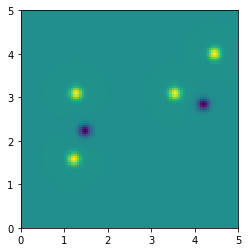

In [46]:
pcolormesh(x,y,data)
plt.gca().set_aspect('equal', adjustable='box')

In [62]:
def make_random_walk(indexs, steps):
    move_dict = {1: go_up,
                 2: go_right,
                 3: go_left,
                 4: go_down,
                 5: go_downleft,
                 6: go_downright,
                 7: go_upleft,
                 8: go_upright,
                 }
    #for _ in range(steps):
    for ii in indexs:
        move_in_a_direction = move_dict[random.randint(1, 8)]
        movcood=move_in_a_direction(ii,steps)
        #print(movcood[0])
        #print(indexs[0],indexs[0]+movcood[0])

    return indexs[0]+movcood[0],indexs[1]+movcood[1]

In [63]:
time=1
moving=True
count=0
while time <= 100:
    [item['loc'].append(list(make_random_walk([item['loc'][time-1][0],item['loc'][time-1][1]],1))) for key,item in eddies.items()]
    #item['loc'].append(list(make_random_walk([item['loc'][time-1][0],item['loc'][time-1][1]],1)))
    time=time+1

In [64]:
x=linspace(0,7,200)
y=linspace(0,7,200)
data=zeros((100,len(x),len(y)))
X,Y=meshgrid(x,y)
for t in range(100):
    for keys, item in eddies.items():
        #print(item['loc'][t][0])
        if item['loc'][t][0]+50 > len(x) or  item['loc'][t][1]+50 > len(x):
            gauss=0
        elif item['loc'][t][0]+50 < 0 or  item['loc'][t][1]+50 < 0:
            gauss=0
        else:
            gauss=twoD_Gaussian((X,Y,item['amp'],x[item['loc'][t][0]+50],y[item['loc'][t][1]+50]),\
                    item['radius'], item['radius'], 0, slopex=0, slopey=0, offset=0).reshape(shape(X))
        data[t,:,:]=data[t,:,:]+gauss

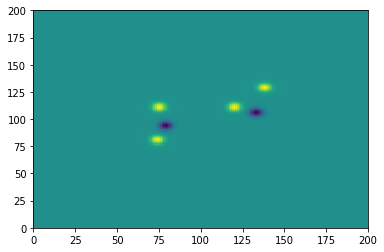

In [65]:
pcolormesh(data[0,:,:])

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
############################
#Create the figure

fig = plt.figure(figsize=(3, 3),facecolor='white')
gs = gridspec.GridSpec(1, 1)

#############################

ax1 = plt.subplot(gs[0,0])

quad1 = ax1.pcolormesh(x,y,data[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)

#line4a, =ax4.plot(lat,sum(zzz[0,:,:],axis=1),'-r')
#ax4.set_ylim([-150,150])

##############################

##############################
#Intitial stage blank
def init():
    quad1.set_array([])
    #quad2.set_array([])
    #line4a.set_data([], [])
    #line4b.set_data([], [])
    #text4.set_text('')
    return quad1,quad2
##############################

##############################
#Animation function, replace the values of the eke in a '1d list'
def animate(iter):
    quad1.set_array(data[iter,:,:].ravel())
    
    #line4a.set_data(lat,sum(zzz[iter,:,:],axis=1))
    return quad1#,quad2
##############################

##############################
#Remove edges
gs.tight_layout(fig)
##############################

##############################
#Animation structure
anim2 = animation.FuncAnimation(fig,animate,frames=100,interval=1000,blit=False,repeat=True)
##############################
plt.close()
##############################
#Display and convert animation to html5
anim2

In [56]:
levels = {'max':data.max(),'min':0.1,'step':0.3}
preferences={'ellipse':0.85,'eccentricity':0.85,'gaussian':0.8}

In [58]:
eddytd=analyseddyzt(data,x,y,0,100,1,levels,preferences=preferences,areamap='',mask='',maskopt='forcefit'
                    ,destdir='',physics='',diagnostics=False,plotdata=False,pprint=True)

 0% [==========>]100% | Elapsed Time: 0 s | Estimated Time: 0 s | Info: Init time |
 0% [==========>]100% | Elapsed Time: 539 s | Estimated Time: 539 s | Info: # of E 1182 |


In [59]:
levels = {'max':data.min(),'min':-0.1,'step':-0.3}
eddytdn=analyseddyzt(data,x,y,0,100,1,levels,preferences=preferences,areamap='',mask='',maskopt='forcefit'
                    ,destdir='',physics='',diagnostics=False,plotdata=False,pprint=True)

 0% [==========>]100% | Elapsed Time: 0 s | Estimated Time: 0 s | Info: Init time |
 0% [==========>]100% | Elapsed Time: 265 s | Estimated Time: 265 s | Info: # of E 597 |


In [60]:
syntetic_gaussian=reconstruct_syntetic(shape(data),x,y,eddytd)+reconstruct_syntetic(shape(data),x,y,eddytdn)

 0% [==========>]100% | Elapsed Time: 1 s | Estimated Time: 1 s | Info: eddyn_19 |
 0% [==========>]100% | Elapsed Time: 1 s | Estimated Time: 1 s | Info: eddyn_54 |


In [61]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
############################
#Create the figure

fig = plt.figure(figsize=(6, 3),facecolor='white')
gs = gridspec.GridSpec(1, 2)

#############################

ax1 = plt.subplot(gs[0,0])

quad1 = ax1.pcolormesh(x,y,data[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)

ax2 = plt.subplot(gs[0,1])

quad2 = ax2.pcolormesh(x,y,syntetic_gaussian[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)


#line4a, =ax4.plot(lat,sum(zzz[0,:,:],axis=1),'-r')
#ax4.set_ylim([-150,150])

##############################

##############################
#Intitial stage blank
def init():
    quad1.set_array([])
    quad2.set_array([])
    #line4a.set_data([], [])
    #line4b.set_data([], [])
    #text4.set_text('')
    return quad1,quad2
##############################

##############################
#Animation function, replace the values of the eke in a '1d list'
def animate(iter):
    quad1.set_array(data[iter,:,:].ravel())
    quad2.set_array(syntetic_gaussian[iter,:,:].ravel())
    
    #line4a.set_data(lat,sum(zzz[iter,:,:],axis=1))
    return quad1,quad2
##############################

##############################
#Remove edges
gs.tight_layout(fig)
##############################

##############################
#Animation structure
anim2 = animation.FuncAnimation(fig,animate,frames=100,interval=1000,blit=False,repeat=True)
##############################
plt.close()
##############################
#Display and convert animation to html5
anim2

In [ ]:
pathp={}
for key,item in eddytd.items():
    pathp[key]=[]
    path=[]
    count=0
    for ii in range(1,item['time'][-1][0]):
        if ii not in item['time']:
            path.append(item['position_eddy'][count,:])
        else:
            path.append(item['position_eddy'][count,:])
            count=count+1 
    pathp[key]=array(path)

In [ ]:
pathn={}
for key,item in eddytdn.items():
    pathn[key]=[]
    path=[]
    count=0
    for ii in range(1,item['time'][-1][0]):
        if ii not in item['time']:
            path.append(item['position_eddy'][count,:])
        else:
            path.append(item['position_eddy'][count,:])
            count=count+1 
    pathn[key]=array(path)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
############################
#Create the figure

fig = plt.figure(figsize=(6, 6),facecolor='white')
gs = gridspec.GridSpec(1, 1)

#############################

ax1 = plt.subplot(gs[0,0])

quad1 = ax1.pcolormesh(x,y,data[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)


line1a, =ax1.plot(pathp['eddyn_0'][0,0],pathp['eddyn_0'][0,1],'*g')
line1b, =ax1.plot(pathp['eddyn_1'][0,0],pathp['eddyn_1'][0,1],'*g')
line1c, =ax1.plot(pathp['eddyn_2'][0,0],pathp['eddyn_2'][0,1],'*g')


line1a, =ax1.plot(pathp['eddyn_0'][0,0],pathp['eddyn_0'][0,1],'-k')
line1b, =ax1.plot(pathp['eddyn_1'][0,0],pathp['eddyn_1'][0,1],'-k')
line1c, =ax1.plot(pathp['eddyn_2'][0,0],pathp['eddyn_2'][0,1],'-k')

line2a, =ax1.plot(pathn['eddyn_0'][0,0],pathn['eddyn_0'][0,1],'*g')
line2b, =ax1.plot(pathn['eddyn_1'][0,0],pathn['eddyn_1'][0,1],'*g')
line2c, =ax1.plot(pathn['eddyn_2'][0,0],pathn['eddyn_2'][0,1],'*g')
#line2d, =ax1.plot(pathn['eddyn_3'][0,0],pathn['eddyn_3'][0,1],'*g')


line2a, =ax1.plot(pathn['eddyn_0'][0,0],pathn['eddyn_0'][0,1],'-k')
line2b, =ax1.plot(pathn['eddyn_1'][0,0],pathn['eddyn_1'][0,1],'-k')
line2c, =ax1.plot(pathn['eddyn_2'][0,0],pathn['eddyn_2'][0,1],'-k')
#line2d, =ax1.plot(pathn['eddyn_3'][0,0],pathn['eddyn_3'][0,1],'-k')
#ax4.set_ylim([-150,150])

##############################

##############################
#Intitial stage blank
def init():
    quad1.set_array([])
    line1a.set_data([], [])
    line1b.set_data([], [])
    line2a.set_data([], [])
    line2b.set_data([], [])
    line2c.set_data([], [])
    line2d.set_data([], [])
    return quad1,quad2
##############################

##############################
#Animation function, replace the values of the eke in a '1d list'
def animate(iter):
    quad1.set_array(data[iter,:,:].ravel())
    line1a.set_data(pathp['eddyn_0'][0:iter+1,0],pathp['eddyn_0'][0:iter+1,1])
    line1b.set_data(pathp['eddyn_1'][0:iter+1,0],pathp['eddyn_1'][0:iter+1,1])
    line1c.set_data(pathp['eddyn_2'][0:iter+1,0],pathp['eddyn_2'][0:iter+1,1])
    line2a.set_data(pathn['eddyn_0'][0:iter+1,0],pathn['eddyn_0'][0:iter+1,1])
    line2b.set_data(pathn['eddyn_1'][0:iter+1,0],pathn['eddyn_1'][0:iter+1,1])
    line2c.set_data(pathn['eddyn_2'][0:iter+1,0],pathn['eddyn_2'][0:iter+1,1])
    #line2d.set_data(pathn['eddyn_3'][0:iter,0],pathn['eddyn_3'][0:iter,1])
    
    return quad1,quad2
##############################

##############################
#Remove edges
gs.tight_layout(fig)
##############################

##############################
#Animation structure
anim2 = animation.FuncAnimation(fig,animate,frames=30,interval=1000,blit=False,repeat=True)
##############################
plt.close()
##############################
#Display and convert animation to html5
anim2